In [ ]:
# Import main DataFrames from the data folder
import matplotlib.pyplot as plt
import pandas as pd

imported_dfs = {}
for name in ["final_trkData", "tcqData", "notifCount", "MWctr", "preQDat", "postQDat"]:
    imported_dfs[name] = pd.read_csv(f"data/{name}.csv", index_col=0)
    print(f"Imported {name} from data/{name}.csv")

# Optionally, unpack to variables:
final_trkData = imported_dfs["final_trkData"]
tcqData = imported_dfs["tcqData"]
notifCount = imported_dfs["notifCount"]
MWctr = imported_dfs["MWctr"]
preQDat = imported_dfs["preQDat"]
postQDat = imported_dfs["postQDat"]

Current working directory: c:\Users\mnand\Desktop\MindWanderAnalysis\Ongoing Data Analysis 2025
Imported final_trkData from data/final_trkData.csv
Imported tcqData from data/tcqData.csv
Imported notifCount from data/notifCount.csv
Imported MWctr from data/MWctr.csv
Imported preQDat from data/preQDat.csv
Imported postQDat from data/postQDat.csv


In [ ]:

from scipy.stats import pearsonr
import seaborn as sns

# --- Correlation between MWQ Score and Mind-Wandering Count ---

# 1. Define MWQ columns from the pre-survey data
mwq_cols = [f'MWQ_{i}' for i in range(1, 6)] # MWQ_1 to MWQ_5

# 2. Score the MWQ by summing the item scores
# Ensure all MWQ columns are numeric, coercing errors
for col in mwq_cols:
    if col in preQDat.columns:
        preQDat[col] = pd.to_numeric(preQDat[col], errors='coerce')

# Get a list of only the MWQ columns that actually exist in the DataFrame
existing_mwq_cols = [col for col in mwq_cols if col in preQDat.columns]
if existing_mwq_cols:
    # Sum the scores for each participant. skipna=False will result in NaN if any item is missing.
    preQDat['MWQ_Score'] = preQDat[existing_mwq_cols].sum(axis=1, skipna=False)
else:
    print("Warning: No MWQ columns found in preQDat. Cannot calculate MWQ score.")
    preQDat['MWQ_Score'] = np.nan
# 3. Prepare the analysis DataFrame
# We need 'MWQ_Score' from preQDat and 'MWrate' from final_trkData.
# Let's merge them on the ExpiWell ID.
analysis_df_mwq = final_trkData[['ExpiWell ID', 'MWrate']].merge(
    preQDat[['MWQ_Score']],
    left_on='ExpiWell ID',
    right_index=True,
    how='inner'
)


# 4. Calculate the Pearson correlation
# Drop any rows with missing data for the correlation
temp_df = analysis_df_mwq[['MWQ_Score', 'MWrate']].dropna()

# Ensure columns are numeric before plotting, which fixes the TypeError
temp_df['MWQ_Score'] = pd.to_numeric(temp_df['MWQ_Score'], errors='coerce')
temp_df['MWrate'] = pd.to_numeric(temp_df['MWrate'], errors='coerce')
temp_df = temp_df.dropna()


if temp_df.shape[0] > 2:
    r, p = pearsonr(temp_df['MWQ_Score'], temp_df['MWrate'])
    result_mwq = {
        'Comparison': 'MWQ Score vs. MW Rate',
        'Pearson r': r,
        'p-value': p,
        'N': temp_df.shape[0]
    }
else:
    result_mwq = {
        'Comparison': 'MWQ Score vs. MW Rate',
        'Pearson r': np.nan,
        'p-value': np.nan,
        'N': temp_df.shape[0]
    }

# 5. Print results and create a scatter plot
results_df_mwq = pd.DataFrame([result_mwq])

print("\n--- Correlation of MWQ Score and Mind-Wandering Rate ---")
print(results_df_mwq.to_string(index=False))

# Visualize the relationship
plt.figure(figsize=(10, 6))
sns.regplot(data=temp_df, x='MWQ_Score', y='MWrate', line_kws={'color': 'red'})
plt.title(f'MWQ Score vs. Mind-Wandering Rate (r={r:.2f}, p={p:.3f})', fontsize=16)
plt.xlabel('MWQ Total Score', fontsize=12)
plt.ylabel('Mind-Wandering Rate (Proportion)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [ ]:

#get the length and colnames
#get the length and colnames
print(f"Shape: {tcqData.shape}")
print(f"Columns: {tcqData.columns.tolist()}")
tcqDataMaster=tcqData.copy()
#ok so its already cleaned
#but we shoudl subset for the participatns whose mind was actually wandering, so ontask >1
tcqData=tcqData[tcqData['onTask']>1]
#specficiically for the CFA, lets not include factors not present in the original
tcq_cols = ['visImag', 'inSpeech', 'intent', 'struct', 'real', 'concAbs', 'import', 'relGoal','oftMind', 'emotVal',]
#drop rows with NaN in any of the tcq_cols
tcqData = tcqData.dropna(subset=tcq_cols)
#lost like 10 rows
within = tcqData.copy()
between = tcqData.copy()
#mean center within participants
within[tcq_cols] = within.groupby("Participant ID")[tcq_cols].transform(lambda x: x - x.mean())
#mean center between participants
#between[tcq_cols] = between.groupby("Participant ID")[tcq_cols].mean()

between = between.groupby("Participant ID")[tcq_cols].mean() - between[tcq_cols].mean()


In [ ]:

#between[tcq_cols] = between[tcq_cols] - between[tcq_cols].mean()


import pandas as pd
import numpy as np
import statsmodels.api as sm

def icc_random_intercept(df, pid_col, item_col):
    """
    ICC for a single item with episodes nested within participant:
      y_ij = mu + u_j + e_ij
      ICC = Var(u) / (Var(u) + Var(e))

    Returns: icc, var_between, var_within, n_obs, n_groups
    """
    dat = df[[pid_col, item_col]].dropna().copy()
    dat[item_col] = pd.to_numeric(dat[item_col], errors="coerce")
    dat = dat.dropna()

    n_obs = dat.shape[0]
    n_groups = dat[pid_col].nunique()

    # Need at least 2 groups and >1 observation per some groups to estimate variance components
    if n_groups < 2 or n_obs < 3:
        return np.nan, np.nan, np.nan, n_obs, n_groups

    # Random intercept model: y ~ 1 + (1|pid)
        # MixedLM in statsmodels uses "groups" for random intercept by default.
    model = sm.MixedLM(endog=dat[item_col], exog=np.ones((n_obs, 1)), groups=dat[pid_col])
    try:
        fit = model.fit(reml=True, method="cg", disp=False)
        if not fit.converged:
             print(f"Warning: Model for '{item_col}' did not converge.")
    except Exception as e:
        print(f"Error fitting model for '{item_col}': {e}")
        return np.nan, np.nan, np.nan, n_obs, n_groups

    # Extract variance components
    var_between = float(fit.cov_re.iloc[0, 0])      # Var(u)
    var_within = float(fit.scale)                  # Var(e)

    icc = var_between / (var_between + var_within) if (var_between + var_within) > 0 else np.nan
    return icc, var_between, var_within, n_obs, n_groups


def icc_table(df, pid_col="pid", tcq_cols=[]):

    rows = []
    for col in tcq_cols:
        icc, vb, vw, n_obs, n_groups = icc_random_intercept(df, pid_col, col)
        rows.append({
            "item": col,
            "ICC": icc,
            "Var_between": vb,
            "Var_within": vw,
            "n_obs": n_obs,
            "n_participants": n_groups
        })

    out = pd.DataFrame(rows).sort_values("ICC", ascending=False)
    return out



iccs = icc_table(tcqData, pid_col="Participant ID", tcq_cols=tcq_cols)
print(iccs.to_string(index=False))




--- Correlation of MWQ Score and Mind-Wandering Rate ---
           Comparison  Pearson r  p-value   N
MWQ Score vs. MW Rate   0.242662 0.004275 137


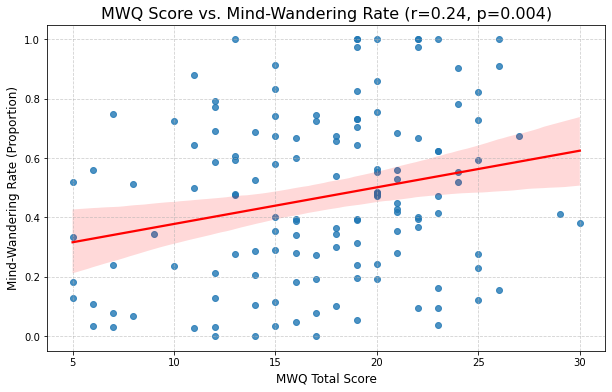

Shape: (4681, 21)
Columns: ['Start Date', 'End Date', 'Time Scheduled', 'Duration (in seconds)', 'expiwellID', 'Participant ID', 'onTask', 'visImag', 'inSpeech', 'intent', 'struct', 'real', 'concAbs', 'import', 'relGoal', 'fullDev', 'oftMind', 'emotVal', 'tempOr', 'funct', 'functOth']
    item      ICC  Var_between  Var_within  n_obs  n_participants
 visImag 0.390667     1.393535    2.173533   2202             133
inSpeech 0.322474     1.055722    2.218093   2202             133
 oftMind 0.319477     0.910192    1.938812   2202             133
  intent 0.297568     0.959215    2.264305   2202             133
  struct 0.294793     0.845923    2.023628   2202             133
 relGoal 0.270053     0.999245    2.700930   2202             133
    real 0.269153     0.734370    1.994079   2202             133
 concAbs 0.265830     0.781540    2.158465   2202             133
  import 0.220744     0.641369    2.264119   2202             133
 emotVal 0.149240     0.288487    1.644559   2202     

-1.0     6.993642
 0.0    55.222525
 1.0    37.783833
Name: tempOr, dtype: float64

Between-Participant Correlation Matrix:


,visImag,inSpeech,intent,struct,real,concAbs,import,relGoal,fullDev,oftMind,emotVal,tempOr
visImag,1.000000,0.166791,0.210658,0.406178,0.202721,0.193000,0.365629,0.340232,0.283133,0.323654,0.375871,-0.005770
inSpeech,0.166791,1.000000,0.127080,0.270724,0.289650,0.206953,0.170272,0.130828,0.133356,0.283720,-0.003165,0.100315
intent,0.210658,0.127080,1.000000,0.389207,0.270714,0.314747,0.172357,0.203651,0.399184,0.068929,0.179439,0.333899
struct,0.406178,0.270724,0.389207,1.000000,0.487848,0.447789,0.555737,0.568389,0.607172,0.474679,0.363328,0.222104
real,0.202721,0.289650,0.270714,0.487848,1.000000,0.805246,0.660151,0.429780,0.450017,0.204033,0.221183,0.301833
concAbs,0.193000,0.206953,0.314747,0.447789,0.805246,1.000000,0.529905,0.255840,0.544174,0.138011,0.217332,0.246756
import,0.365629,0.170272,0.172357,0.555737,0.660151,0.529905,1.000000,0.671222,0.510729,0.511479,0.458099,0.201014
relGoal,0.340232,0.130828,0.203651,0.568389,0.429780,0.255840,0.671222,1.000000,0.471521,0.583035,0.397896,0.233426
fullDev,0.283133,0.133356,0.399184,0.607172,0.450017,0.544174,0.510729,0.471521,1.000000,0.419993,0.357938,0.085210
oftMind,0.323654,0.283720,0.068929,0.474679,0.204033,0.138011,0.511479,0.583035,0.419993,1.000000,0.401436,0.092269



Within-Participant Correlation Matrix:


,visImag,inSpeech,intent,struct,real,concAbs,import,relGoal,fullDev,oftMind,emotVal,tempOr
visImag,1.000000,-0.048418,0.044897,0.065207,0.044541,0.111627,0.070737,-0.013984,0.086370,-0.012581,0.119023,-0.004429
inSpeech,-0.048418,1.000000,0.017470,0.193132,0.085337,0.056733,0.151250,0.108612,0.065228,0.094292,0.024012,0.025113
intent,0.044897,0.017470,1.000000,0.162161,0.203669,0.194890,0.182081,0.166827,0.208454,0.092962,0.127715,-0.017320
struct,0.065207,0.193132,0.162161,1.000000,0.233111,0.257363,0.250508,0.226516,0.196047,0.089614,0.060117,-0.000668
real,0.044541,0.085337,0.203669,0.233111,1.000000,0.460017,0.418519,0.328001,0.289358,0.147465,0.151890,-0.045583
concAbs,0.111627,0.056733,0.194890,0.257363,0.460017,1.000000,0.366147,0.284942,0.326653,0.123133,0.122816,-0.075813
import,0.070737,0.151250,0.182081,0.250508,0.418519,0.366147,1.000000,0.385525,0.312855,0.283156,0.139062,-0.013161
relGoal,-0.013984,0.108612,0.166827,0.226516,0.328001,0.284942,0.385525,1.000000,0.267924,0.231073,0.140425,0.032757
fullDev,0.086370,0.065228,0.208454,0.196047,0.289358,0.326653,0.312855,0.267924,1.000000,0.138016,0.133152,-0.073712
oftMind,-0.012581,0.094292,0.092962,0.089614,0.147465,0.123133,0.283156,0.231073,0.138016,1.000000,0.056963,0.035323


Columns passed to CFA model: ['visImag', 'inSpeech', 'intent', 'struct', 'real', 'concAbs', 'import', 'relGoal', 'fullDev', 'oftMind', 'emotVal', 'tempOr']
--- SEMOPY Stats Output ---
       DoF  DoF Baseline        chi2  chi2 p-value  chi2 Baseline       CFI  \
Value   22            36  187.279508           0.0    2350.593342  0.928592   

            GFI      AGFI       NFI       TLI     RMSEA        AIC  \
Value  0.920327  0.869626  0.920327  0.883151  0.058424  45.829901   

              BIC   LogLik  
Value  176.863691  0.08505  
---------------------------
WITHIN-LEVEL CFA fit: {'n': 2202, 'chi2': 187.27950819315703, 'df': 22, 'p': 0.0, 'cfi': 0.9285924204614323, 'tli': 0.8831512334823437, 'rmsea': 0.0584235771348331, 'srmr': 'Not available'}
       lval           rval  Est. Std p-value
1  inSpeech         Format -0.221772       -
0   visImag         Format  0.220343       -
6   concAbs        Realism  0.652134     0.0
5      real        Realism  0.705106       -
2    import    

In [ ]:


# Recode the 'tempOr' column: Past (1) -> -1; Present (2) -> 0; Future (3) -> 1; No specific time (4) -> 0
tempOr_recode_map = {1: -1, 2: 0, 3: 1, 4: 0}
tcqData['tempOr'] = tcqData['tempOr'].replace(tempOr_recode_map)
print("Recoded 'tempOr' column. Displaying a sample:")
display(tcqData['tempOr'].value_counts(normalize=True).sort_index() * 100)
# --- Temporal Orientation Distribution Across Participants ---
""" 
# Group by participant and get the normalized value counts for 'tempOr'
participant_tempOr_dist = tcqData.groupby('expiwellID')['tempOr'].value_counts(normalize=True).unstack(fill_value=0) * 100

# It's possible a participant never used a certain category, so let's ensure all 4 columns exist
for i in range(1, 5):
    if i not in participant_tempOr_dist.columns:
        participant_tempOr_dist[i] = 0

# Rename columns for clarity based on the survey codes: 1=Past, 2=Present, 3=Future, 4=No specific time
participant_tempOr_dist = participant_tempOr_dist.rename(columns={
    1.0: 'Past (%)',
    2.0: 'Present (%)',
    3.0: 'Future (%)',
    4.0: 'No Specific Time (%)'
})


print("--- Distribution of Temporal Orientation Percentages Across Participants ---")
print("\nExample percentages for the first 5 participants:")
display(participant_tempOr_dist.head())

print("\nSummary statistics for these percentages across all participants:")
print("This shows the average (mean), spread (std), and range (min/max) of temporal focus.")
display(participant_tempOr_dist.describe())


# --- Plot for "No Specific Time" Proportion ---
no_time_props = participant_tempOr_dist['No Specific Time (%)'].sort_values(ascending=False)

plt.figure(figsize=(20, 6))
plt.bar(no_time_props.index, no_time_props.values, color='skyblue')
plt.title('Proportion of "No Specific Time" Mind-Wandering Episodes per Participant', fontsize=16)
plt.xlabel('Participant ExpiWell ID', fontsize=12)
plt.ylabel('Percentage of Episodes (%)', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# --- Plot for "Past" Proportion ---
past_props = participant_tempOr_dist['Past (%)'].sort_values(ascending=False)

plt.figure(figsize=(20, 6))
plt.bar(past_props.index, past_props.values, color='coral')
plt.title('Proportion of "Past" Mind-Wandering Episodes per Participant', fontsize=16)
plt.xlabel('Participant ExpiWell ID', fontsize=12)
plt.ylabel('Percentage of Episodes (%)', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Plot for "Present" Proportion ---
present_props = participant_tempOr_dist['Present (%)'].sort_values(ascending=False)

plt.figure(figsize=(20, 6))
plt.bar(present_props.index, present_props.values, color='lightgreen')
plt.title('Proportion of "Present" Mind-Wandering Episodes per Participant', fontsize=16)
plt.xlabel('Participant ExpiWell ID', fontsize=12)
plt.ylabel('Percentage of Episodes (%)', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Plot for "Future" Proportion ---
future_props = participant_tempOr_dist['Future (%)'].sort_values(ascending=False)

plt.figure(figsize=(20, 6))
plt.bar(future_props.index, future_props.values, color='lightblue')
plt.title('Proportion of "Future" Mind-Wandering Episodes per Participant', fontsize=16)
plt.xlabel('Participant ExpiWell ID', fontsize=12)
plt.ylabel('Percentage of Episodes (%)', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Proportional Stacked Bar Chart of Temporal Orientations ---

# 1. Calculate the proportion of each temporal orientation for each participant
participant_tempOr_props = tcqData.groupby('expiwellID')['tempOr'].value_counts(normalize=True).unstack(fill_value=0)

# 2. Ensure all four categories exist as columns, even if unused
for i in range(1, 5):
    if i not in participant_tempOr_props.columns:
        participant_tempOr_props[i] = 0

# 3. Sort participants by the proportion of "No Specific Time" (tempOr == 4) episodes
sorted_proportions = participant_tempOr_props.sort_values(by=4, ascending=True)

# 4. Rename columns for a clear legend
sorted_proportions = sorted_proportions.rename(columns={
    1: 'Past',
    2: 'Present',
    3: 'Future',
    4: 'No Specific Time'
})

# 5. Reorder columns for a logical stack in the plot
sorted_proportions = sorted_proportions[['Past', 'Present', 'Future', 'No Specific Time']]

# 6. Create the stacked bar plot
ax = sorted_proportions.plot(
    kind='bar',
    stacked=True,
    figsize=(20, 10),
    color=['coral', 'lightgreen', 'lightblue', 'skyblue'],
    width=0.8
)

# 7. Customize the plot for clarity
ax.set_title('Proportion of Temporal Orientations per Participant', fontsize=18)
ax.set_xlabel('Participant ExpiWell ID (Sorted by "No Specific Time" Proportion)', fontsize=14)
ax.set_ylabel('Proportion of Mind-Wandering Episodes', fontsize=14)
ax.tick_params(axis='x', rotation=90, labelsize=8)
ax.tick_params(axis='y', labelsize=10)
ax.legend(title='Temporal Orientation', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_ylim(0, 1) # Proportions sum to 1
plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for legend
plt.show()

# --- Analyze Trade-offs in Temporal Orientation ---

# To understand what "No Specific Time" trades off with, we can calculate
# the correlation matrix of the proportions of each temporal category.
# A strong negative correlation indicates that as one proportion goes up, the other goes down.
proportion_correlations = sorted_proportions.corr()

print("\n--- Correlation Matrix of Temporal Orientation Proportions ---")
print("This matrix shows how the proportion of each category relates to the others across participants.")
print("A strong negative value means that as one category's proportion increases, the other's tends to decrease.")
display(proportion_correlations)

# Find the strongest negative correlation with 'No Specific Time'
trade_off = proportion_correlations['No Specific Time'].sort_values().iloc[0]
trade_off_category = proportion_correlations['No Specific Time'].sort_values().index[0]

print(f"\nThe strongest trade-off for 'No Specific Time' is with '{trade_off_category}' (r = {trade_off:.2f}).")
print(f"This suggests that participants who have a higher proportion of 'No Specific Time' thoughts tend to have a correspondingly lower proportion of '{trade_off_category}' thoughts.")
 """

tcq_cols = ['visImag', 'inSpeech', 'intent', 'struct', 'real', 'concAbs', 'import', 'relGoal', 'fullDev', 'oftMind', 'emotVal', 'tempOr']

#this is all the factors except funct and functOth, as opposed to the 10 used in the
# cfa
between = tcqData.groupby("expiwellID")[tcq_cols].mean()



# Calculate and display the between-participant correlation matrix
between_corr = between[tcq_cols].corr()

print("Between-Participant Correlation Matrix:")
display(between_corr)

# Calculate and display the within-participant correlation matrix
within_corr = within[tcq_cols].corr()

print("\nWithin-Participant Correlation Matrix:")
display(within_corr)
from semopy import Model, calc_stats

model_desc = """
Format =~ 1*visImag + -1*inSpeech
Relevance =~ import + relGoal + oftMind
Realism =~ real + concAbs
Structuration =~ struct + intent

# allow factor correlations
Format ~~ Relevance
Format ~~ Realism
Format ~~ Structuration
Relevance ~~ Realism
Relevance ~~ Structuration
Realism ~~ Structuration
"""
def fit_cfa(data, model_desc):
    mod = Model(model_desc)
    mod.fit(data)
    stats = calc_stats(mod)
    
    # Print the stats DataFrame to see available keys
    print("--- SEMOPY Stats Output ---")
    print(stats)
    print("---------------------------")

    fit = {
        "n": data.shape[0],
        "chi2": stats.loc["Value", "chi2"],
        "df": stats.loc["Value", "DoF"],
        "p": stats.loc["Value", "chi2 p-value"],
        "cfi": stats.loc["Value", "CFI"],
        "tli": stats.loc["Value", "TLI"],
        "rmsea": stats.loc["Value", "RMSEA"],
        "srmr": "Not available" # SRMR is not in the output
    }
    est = mod.inspect(std_est=True)
    return mod, fit, est

# Within CFA
Xw = within[tcq_cols].dropna()
print("Columns passed to CFA model:", Xw.columns.tolist())

mod_w, fit_w, est_w = fit_cfa(Xw, model_desc)

print("WITHIN-LEVEL CFA fit:", fit_w)

# Standardized loadings
load_w = est_w[(est_w["op"] == "~") & (est_w["lval"].isin(tcq_cols))]
print(load_w[["lval","rval","Est. Std","p-value"]].sort_values(["rval","lval"]))

# --- Between-Level CFA ---

# Define the between-level model based on the provided description
model_desc_b = """
# Factor 1: Imagery & Structure
ImageryStruct =~ visImag + emotVal + intent + struct

# Factor 2: Relevance
Relevance =~ import + relGoal + oftMind

# Factor 3: Realism
Realism =~ real + concAbs


"""

# Prepare the between-level data
# Note: 'inSpeech' is in tcq_cols but not in the model, semopy will handle this.
Xb = between[tcq_cols].dropna()

print("\n--- Running Between-Level CFA ---")
# Fit the CFA model
mod_b, fit_b, est_b = fit_cfa(Xb, model_desc_b)

print("\nBETWEEN-LEVEL CFA fit:", fit_b)

# Display standardized loadings
print("\nStandardized Loadings (Between-Level):")
load_b = est_b[(est_b["op"] == "~") & (est_b["lval"].isin(tcq_cols))]
print(load_b[["lval","rval","Est. Std","p-value"]].sort_values(["rval","lval"]))